In [8]:
import os

import numpy as np
from sklearn.cluster import KMeans
from sklearn.preprocessing import minmax_scale
from sklearn.preprocessing import normalize
from skimage.metrics import structural_similarity as ssim
from math import sqrt

import pandas as pd
import seaborn as sns

import tqdm
import matplotlib.pyplot as plt
plt.style.use("dark_background")
import matplotlib.backends.backend_pdf

In [63]:
EXP_NUM = 88

EXP_DIR = f'/home/avic/om2/exp{EXP_NUM}'
INTERMEDIATE_OUTPUTS_PATH = os.path.join(EXP_DIR, 'eval/intermediate_outputs')
def HEATMAPS_PATH(data_div, layer): return os.path.join(INTERMEDIATE_OUTPUTS_PATH, f'{data_div}_{layer}_heatmaps.npy')
layers = ['avgpool']
# layers = ['layer1_1_conv2', 'layer2_1_conv2', 'layer3_1_conv2', 'layer4_1_conv2', 'avgpool']
# layers = ['avgpool']

In [64]:
DATA_DIVS = range(10, 41, 6)
def convert_dd_to_idx(idx): return {10:0, 16:1, 22:2, 28:3, 34:4, 40:5}[idx]

heatmaps = [{layer: None for layer in layers} for _ in range(len(DATA_DIVS))]

def apply_to_all_heatmaps(callback):
    for i, data_div in enumerate(DATA_DIVS):
        for layer in layers:
            callback(i, data_div, layer)

def load_heatmaps(i, data_div, layer):
    heatmaps[i][layer] = np.load(HEATMAPS_PATH(data_div, layer)) if layer != 'avgpool' else np.load(HEATMAPS_PATH(data_div, layer)) #(l - l.min())/(l.max() - l.min()) #normalize(l.reshape((-1, 625)), axis=1).reshape(l_shape)
    
apply_to_all_heatmaps(load_heatmaps)

In [6]:
def get_relevant_heatmaps(dd, layer, pool):
    dd_idx = convert_dd_to_idx(dd)
    return (heatmaps[dd_idx][layer][0 if pool == 'avg' else 1] if layer != 'avgpool' else heatmaps[dd_idx][layer]).transpose((0, 2, 1, 3, 4))

In [7]:
def draw(relevant_heatmaps, pick):
    plt.close('all')
    fig, axes = plt.subplots(7, 7, figsize=(35,30))
    fig.tight_layout()
    image_normal = plt.Normalize(vmin=np.min(relevant_heatmaps[:, pick]), vmax=np.max(relevant_heatmaps[:, pick]))
    for i in range(49):
        y, x = i % 7, i // 7
        axes[x][y].imshow(relevant_heatmaps[i, pick], norm=image_normal, cmap='plasma')
        axes[x][y].set_xticks([])
        axes[x][y].set_yticks([])
        axes[x][y].set_title(i, fontsize=30)
#     axes[50 // 17][50 % 17].axis('off')
    plt.show()

In [31]:
def closest(relevant_heatmaps, draw=False, n_clusters=9):

    relevant_heatmaps = relevant_heatmaps.reshape((-1, 625))
    X = normalize(relevant_heatmaps, axis=1)
    kmeans = KMeans(n_clusters=n_clusters, random_state=0, n_jobs=10).fit(X)
    closest_heatmaps = np.argpartition(kmeans.transform(X).T, kth=1)[:,0]
    
    if draw:
        plt.close('all')
        fig, axes = plt.subplots(3, 3, figsize=(5,5))
        fig.tight_layout(pad=0.3)
        for i in range(n_clusters):
            y, x = i % 3, i // 3
            axes[x][y].imshow(relevant_heatmaps[closest_heatmaps[i]].reshape((25, 25)), cmap='plasma')   
            axes[x][y].set_xticks([])
            axes[x][y].set_yticks([])
            axes[x][y].set_title(f'{i}, {len(np.where(kmeans.labels_ == i)[0])}')
        plt.show()
    
    return kmeans, relevant_heatmaps[closest_heatmaps]

In [32]:
def draw_items_in_cluster(relevant_heatmaps, kmeans, cluster):
    samples = np.where(kmeans.labels_ == cluster)[0]
    
    plt.close('all')
    fig, axes = plt.subplots(8, 8, figsize=(10,10))
    fig.tight_layout(pad=0.3)
    for i in range(64):
        y, x = i % 8, i // 8
        axes[x][y].imshow(relevant_heatmaps[samples[i]])   
        axes[x][y].set_xticks([])
        axes[x][y].set_yticks([])
    plt.show()

In [33]:
def generate_masks(kmeans_data, threshold=0.7, draw=False):
    kmeans, closest_heatmaps = kmeans_data
    n_clusters = kmeans.get_params()['n_clusters']
    scaled_closest_heatmaps = minmax_scale(closest_heatmaps.reshape((-1, 625)), axis=1)
    mask = scaled_closest_heatmaps > threshold
    masked_closest_heatmaps = np.zeros(scaled_closest_heatmaps.shape)
    masked_closest_heatmaps[mask] = scaled_closest_heatmaps[mask]
    masked_closest_heatmaps = normalize(masked_closest_heatmaps.reshape((-1, 625)), axis=1, norm='l1')
    if draw:
        fig, axes = plt.subplots(1,3, figsize=(15, 20))
        plt.tight_layout()
        axes[0].imshow(closest_heatmaps.reshape(n_clusters * 25, 25), cmap='plasma')
        axes[0].set_title('Cluster Centers', fontsize=30)
        axes[1].imshow(mask.reshape(n_clusters * 25, 25), cmap='plasma')
        axes[1].set_title('Masks', fontsize=30)
        axes[2].imshow(masked_closest_heatmaps.reshape(n_clusters * 25, 25), cmap='plasma')
        axes[2].set_title('Normalized Centers', fontsize=30)
        for i in range(3):
            axes[i].set_xticks([])
            axes[i].set_yticks([])
        plt.show()
    return masked_closest_heatmaps

In [34]:
def n_activations(relevant_heatmaps, masked_closest_heatmaps):
    relevant_heatmaps_shape = relevant_heatmaps.shape[:2]
    relevant_heatmaps = relevant_heatmaps.reshape((-1, 625))
    sims_cols = np.apply_along_axis(lambda cluster: np.dot(relevant_heatmaps, cluster), arr=masked_closest_heatmaps, axis=1).reshape(((masked_closest_heatmaps.shape[0],) + relevant_heatmaps_shape))
    return sims_cols

In [35]:
from joblib import Parallel, delayed
import os
from joblib import dump, load

def n_ssim(relevant_heatmaps, kmeans_data, n_jobs=8):
    
    
    folder = '/home/avic/training_scripts/joblib_memmap'
    try:
        os.mkdir(folder)
    except FileExistsError:
        pass

    kmeans, closest_heatmaps = kmeans_data
    n_clusters = kmeans.get_params()['n_clusters']
    
    reshaped_closest_heatmaps = minmax_scale(closest_heatmaps).reshape((-1, 25, 25))
    relevant_heatmaps = minmax_scale(relevant_heatmaps.reshape((-1, 625))).reshape(relevant_heatmaps.shape)
    ssim_results_shape = relevant_heatmaps.shape[0:-2]
    
    output_filename_memmap = os.path.join(folder, 'output_memmap')
    ssim_results = np.memmap(output_filename_memmap, dtype=np.float32, shape=(ssim_results_shape[0],) + (n_clusters,) + ssim_results_shape[1:], mode='w+')
    cluster_range_array = np.array(range(n_clusters))
    
    def a(index, ssim_results):
        for cluster_index in range(n_clusters):
            ssim_results[index[0],cluster_index][index[1:]] = ssim(relevant_heatmaps[index], reshaped_closest_heatmaps[cluster_index])
    
    Parallel(n_jobs=n_jobs)(delayed(a)(index, ssim_results) for index in tqdm.tqdm(np.ndindex(ssim_results_shape), total=np.prod(ssim_results_shape), position=0, leave=True))
    
#     for index in tqdm.tqdm(np.ndindex(iter_indxs), total=np.prod(iter_indxs)):
#         ssim_results[index] = ssim(relevant_heatmaps[(index[0],) + index[2:]], reshaped_closest_heatmaps[index[1]])
    return ssim_results
    

In [36]:
def n_invars(relevant_heatmaps, masked_closest_heatmaps):
    relevant_heatmaps_shape = relevant_heatmaps.shape[:2]
    relevant_heatmaps = relevant_heatmaps.reshape((-1, 625))
    invariances = 1 - np.apply_along_axis(lambda cluster: np.sum(((relevant_heatmaps - np.sum(relevant_heatmaps * cluster, axis=1)[:,np.newaxis]) ** 2) * cluster, axis=1), arr=masked_closest_heatmaps, axis=1).reshape(((masked_closest_heatmaps.shape[0],) + relevant_heatmaps_shape))
    return invariances

In [37]:
def draw_cols(df, col, data_div, neurons):
    
    cols = df[(df.data_div == data_div) & (df.neuron.isin(neurons))].groupby([df.neuron]).apply(lambda group: group[col].to_numpy().reshape(6,50).T)
    
    plt.close('all')
    fig, axes = plt.subplots(1, len(neurons), figsize=(35,100))
    fig.tight_layout()
    
    for i, pick in enumerate(neurons):
        axes[i].imshow(cols[i], cmap='plasma')
        axes[i].set_xticks([])
        axes[i].set_title(neurons[i], fontsize=20)
        axes[i].tick_params(labelsize=20)
    
    plt.show()

In [71]:
def generate_stats(relevant_heatmaps, kmeans_data, closest_threshold=0.7, threshold=0.9):

    n_clusters = kmeans[0].get_params()['n_clusters']
       
    df = pd.DataFrame(((dd, n, c, cat) for dd in DATA_DIVS for n in range(relevant_heatmaps[0].shape[1]) for c in range(n_clusters) for cat in range(50)), columns=['data_div', 'neuron', 'cluster', 'category'])
    
    ssim = n_ssim(relevant_heatmaps, kmeans)
    masked_closest = generate_masks(kmeans, threshold=closest_threshold, draw=False)
    activations = np.stack([n_activations(relevant_heatmaps[i], masked_closest) for i in range(len(DATA_DIVS))], axis=0)
    invariances = np.stack([n_invars(relevant_heatmaps[i], masked_closest) for i in range(len(DATA_DIVS))], axis=0)
    
    def to_df(arr): return np.moveaxis(arr, 3, 1).flatten()
    
    similarity = ssim * activations
    df['ssim'] = to_df(ssim)
    df['activations'] = to_df(activations)
    df['similarity'] = to_df(similarity)
    selective_to = similarity >= np.broadcast_to((np.amax(similarity, axis=(1,2)) * threshold)[:,np.newaxis,np.newaxis,:], similarity.shape)
    df['invariance'] = to_df(selective_to * invariances)
    df['selective_to'] = to_df(selective_to)
    
    return df

In [39]:
def get_unique_categories(df, base=0):
    
    def driver(group):
        base_selectivity_frame = df[(df.data_div == group.name[0]) & (df.cluster == base)]
        base_shared_selectivity = base_selectivity_frame[base_selectivity_frame.neuron.isin(group.neuron)].selective_to.reset_index()
        group_shared_selectivity = group[group.neuron.isin(base_selectivity_frame.neuron)].selective_to.reset_index()
        return  np.sum(base_shared_selectivity & group_shared_selectivity) / np.sum(base_shared_selectivity | group_shared_selectivity) * 100
    
    return df.groupby([df.data_div, df.cluster], as_index=False).apply(lambda group: driver(group)).replace(np.nan, 0)

In [65]:
relevant_heatmaps = np.array([heatmaps[dd_idx]['avgpool'] for dd_idx in range(6)])

In [68]:
relevant_heatmaps = np.moveaxis(relevant_heatmaps.squeeze(), 2, 1)

/home/avic/.local/lib/python3.7/site-packages/sklearn/cluster/_kmeans.py:974: FutureWarning: 'n_jobs' was deprecated in version 0.23 and will be removed in 0.25.
  " removed in 0.25.", FutureWarning)


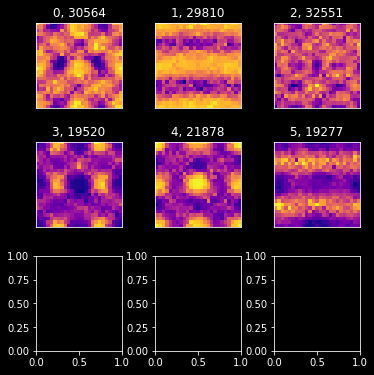

In [70]:
kmeans = closest(relevant_heatmaps, draw=True, n_clusters=6)

In [ ]:
plt.close('all')
fig, axes = plt.subplots(1, 6, figsize=(20,14))
# fig.tight_layout(pad=0)
for i in range(6):
    y, x = i % 1, i // 6
    axes[i].imshow(kmeans[1][i].reshape((25, 25)), cmap='plasma')   
    axes[i].set_xticks([])
    axes[i].set_yticks([])
    axes[i].set_title(i, fontsize=30)
plt.show()

In [72]:
d = generate_stats(relevant_heatmaps, kmeans, threshold=0.4)

100%|██████████| 153600/153600 [01:10<00:00, 2170.74it/s]


In [73]:
d.to_csv(os.path.join(EXP_DIR, 'eval', 'neuron_stats.csv'))

In [49]:
d = pd.read_csv(os.path.join(EXP_DIR, 'eval', 'neuron_stats.csv'))

In [79]:
def get_neurons(df):
    def get_funcs(t):
        if t == 'unseen':
            return(np.equal, np.greater)
        elif t == 'seen':
            return (np.greater, np.equal)
        elif t == 'mixed':
            return (np.greater, np.greater)
        elif t == 'neither':
            return (np.equal, np.equal)
        else:
            print(f'Error: unknown argument - {t}')
        
    def a(f):
        first_to_0, second_to_0 = get_funcs(f)
        return df.groupby([df.data_div, df.neuron, df.cluster]).filter(lambda group: \
        first_to_0(np.sum(group[group.category < group.name[0]].selective_to), 0) & \
        second_to_0(np.sum(group[group.category >= group.name[0]].selective_to), 0)).reset_index(drop=True)
    
    results = Parallel(n_jobs=4)(delayed(a)(f) for f in ['unseen', 'seen', 'mixed', 'neither'])
    return results

In [80]:
unseen, seen, mixed, neither = get_neurons(d)

In [81]:
unseen.to_csv(os.path.join(EXP_DIR, 'eval', 'unseen_stats.csv'))
seen.to_csv(os.path.join(EXP_DIR, 'eval', 'seen_stats.csv'))
mixed.to_csv(os.path.join(EXP_DIR, 'eval', 'mixed_stats.csv'))
neither.to_csv(os.path.join(EXP_DIR, 'eval', 'neither_stats.csv'))

In [ ]:
unseen = pd.read_csv(os.path.join(EXP_DIR, 'eval', 'unseen_stats2.csv'))
seen = pd.read_csv(os.path.join(EXP_DIR, 'eval', 'seen_stats2.csv'))
mixed = pd.read_csv(os.path.join(EXP_DIR, 'eval', 'mixed_stats2.csv'))
neither = pd.read_csv(os.path.join(EXP_DIR, 'eval', 'neither_stats2.csv'))

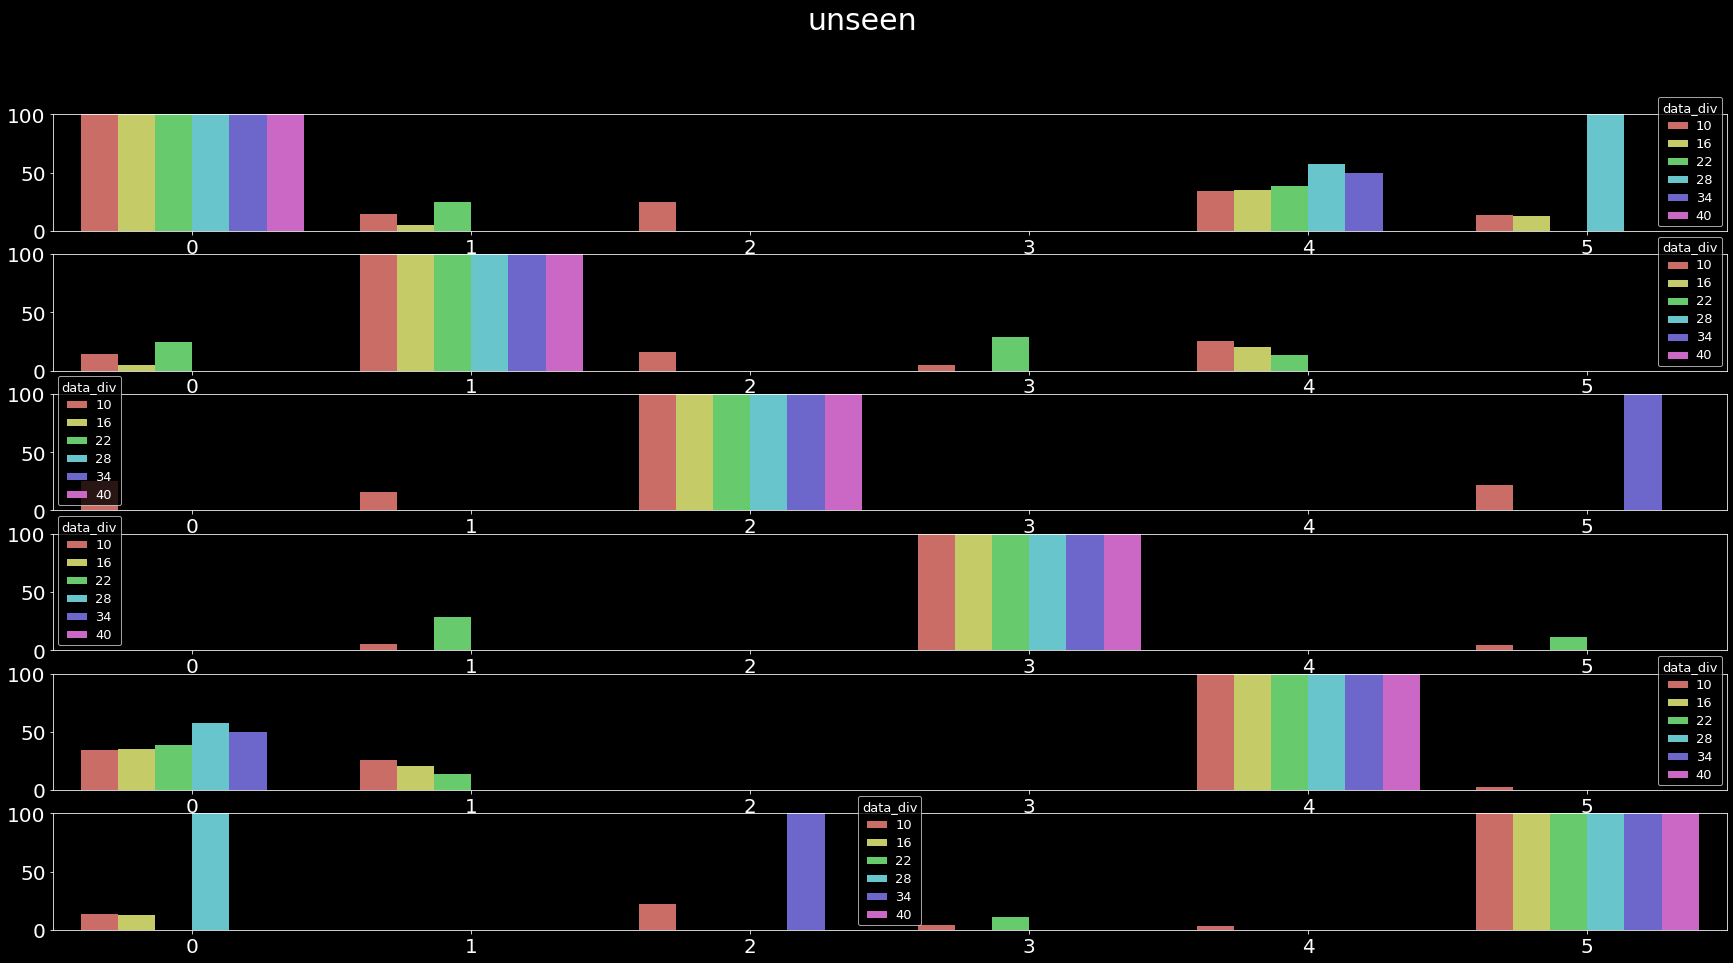

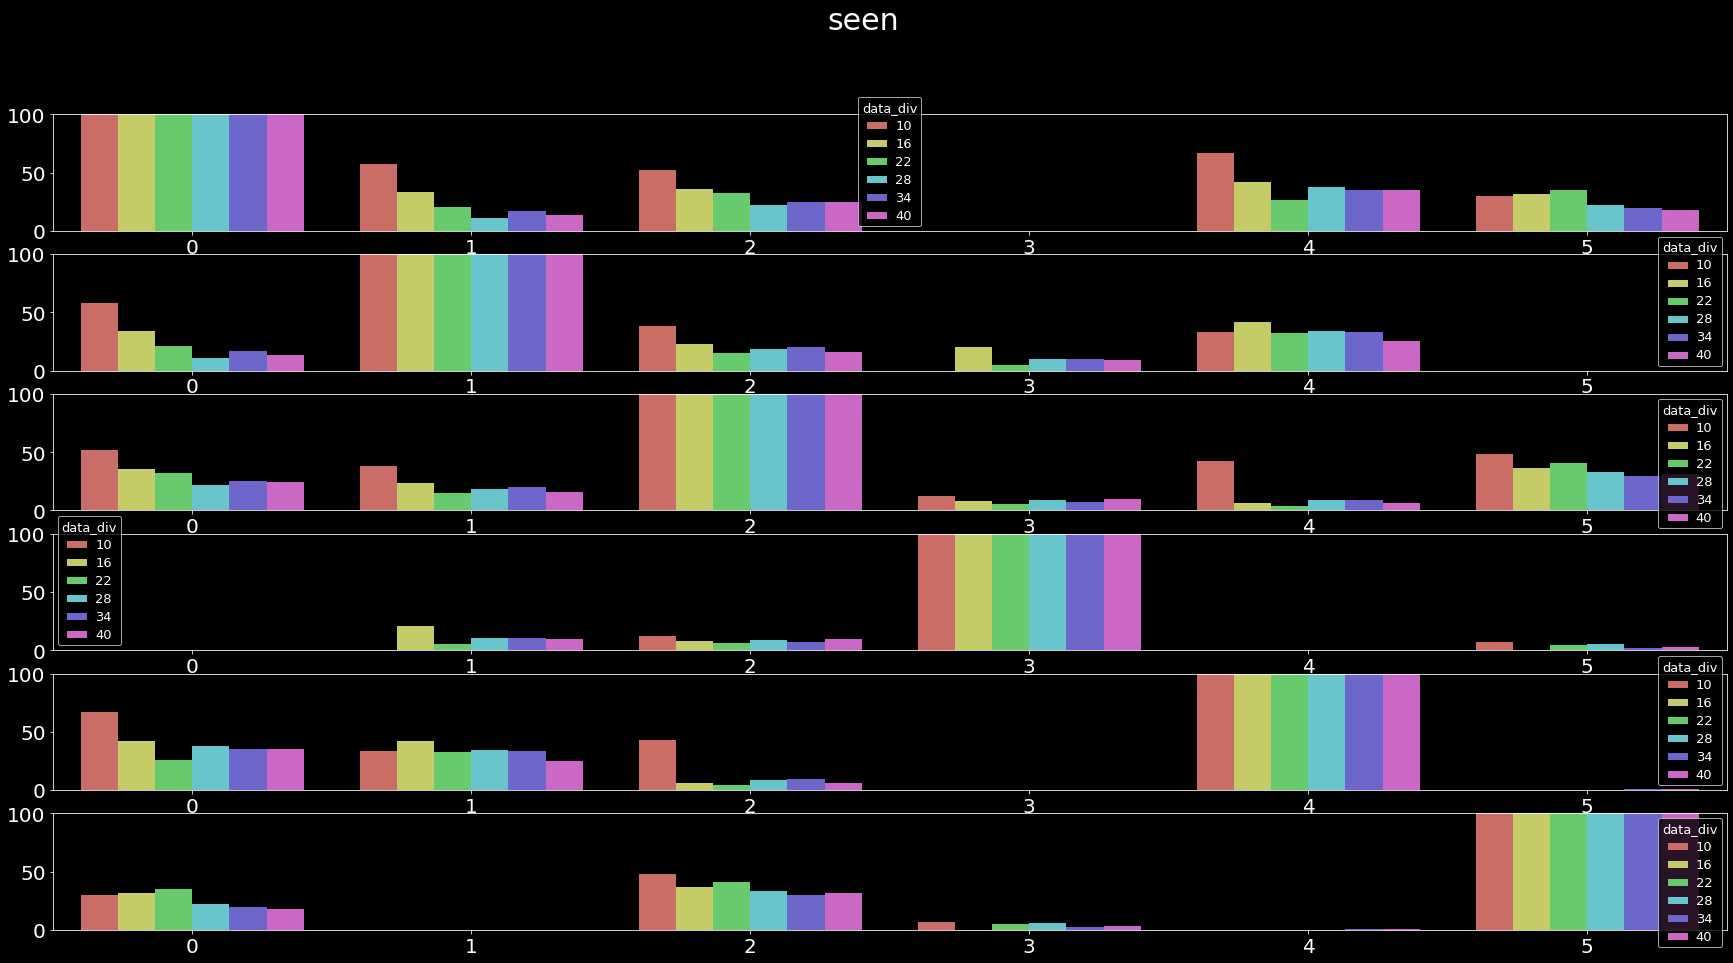

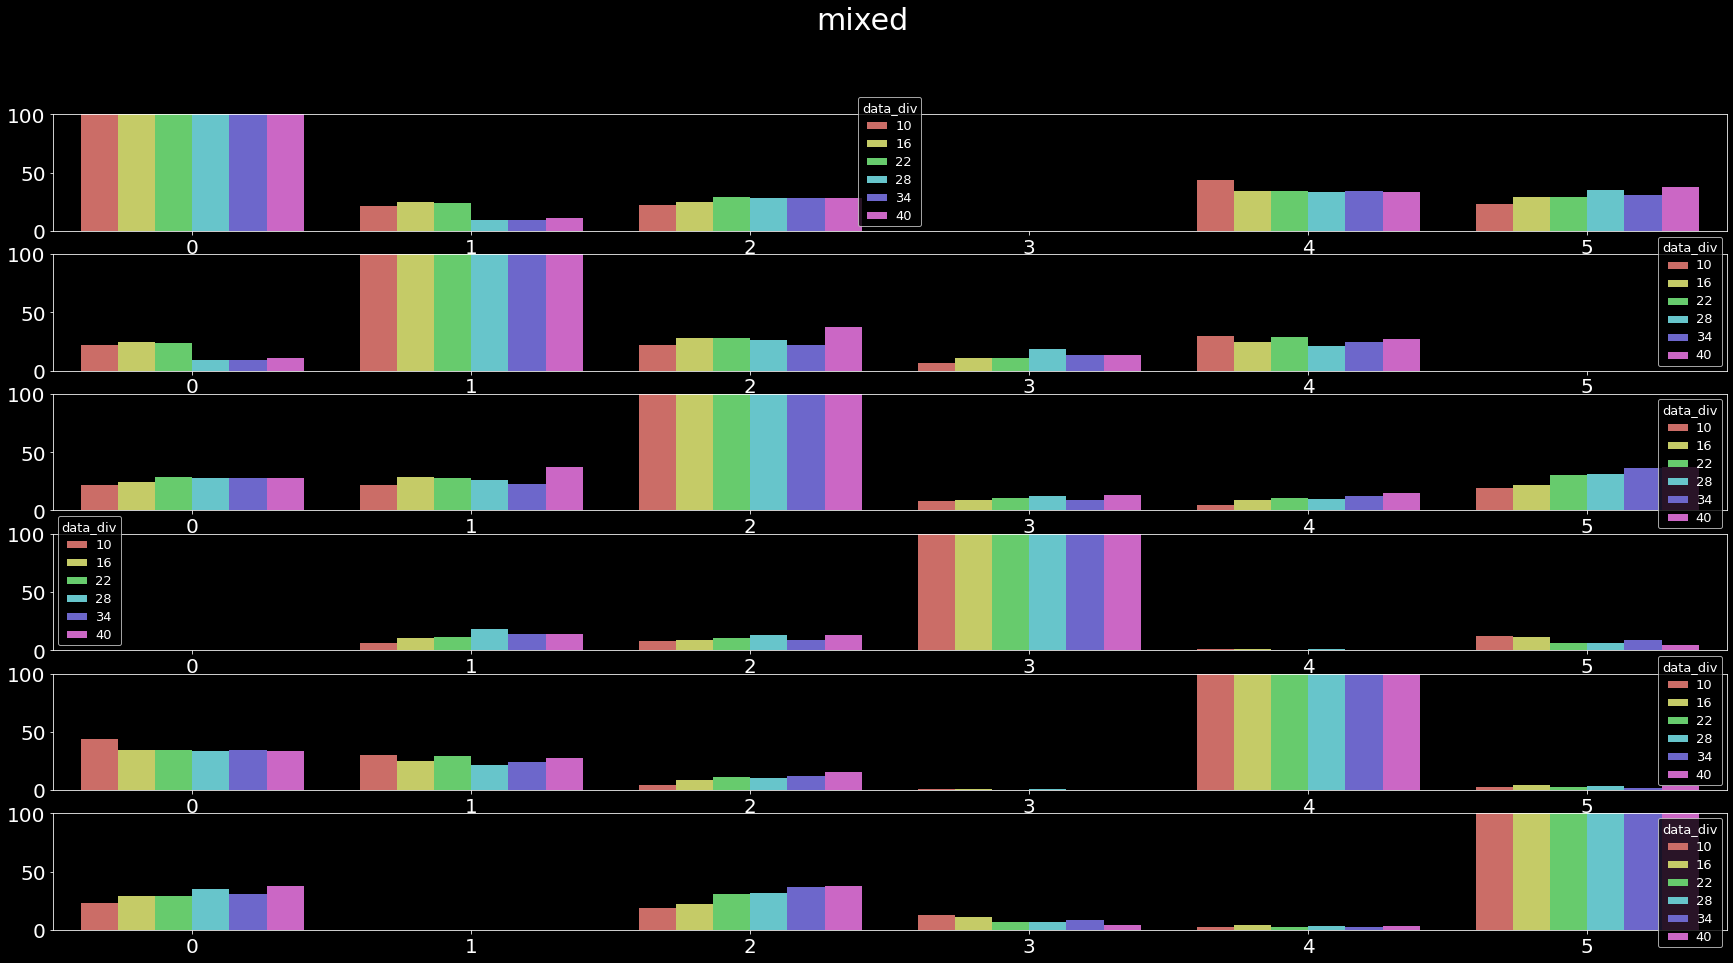

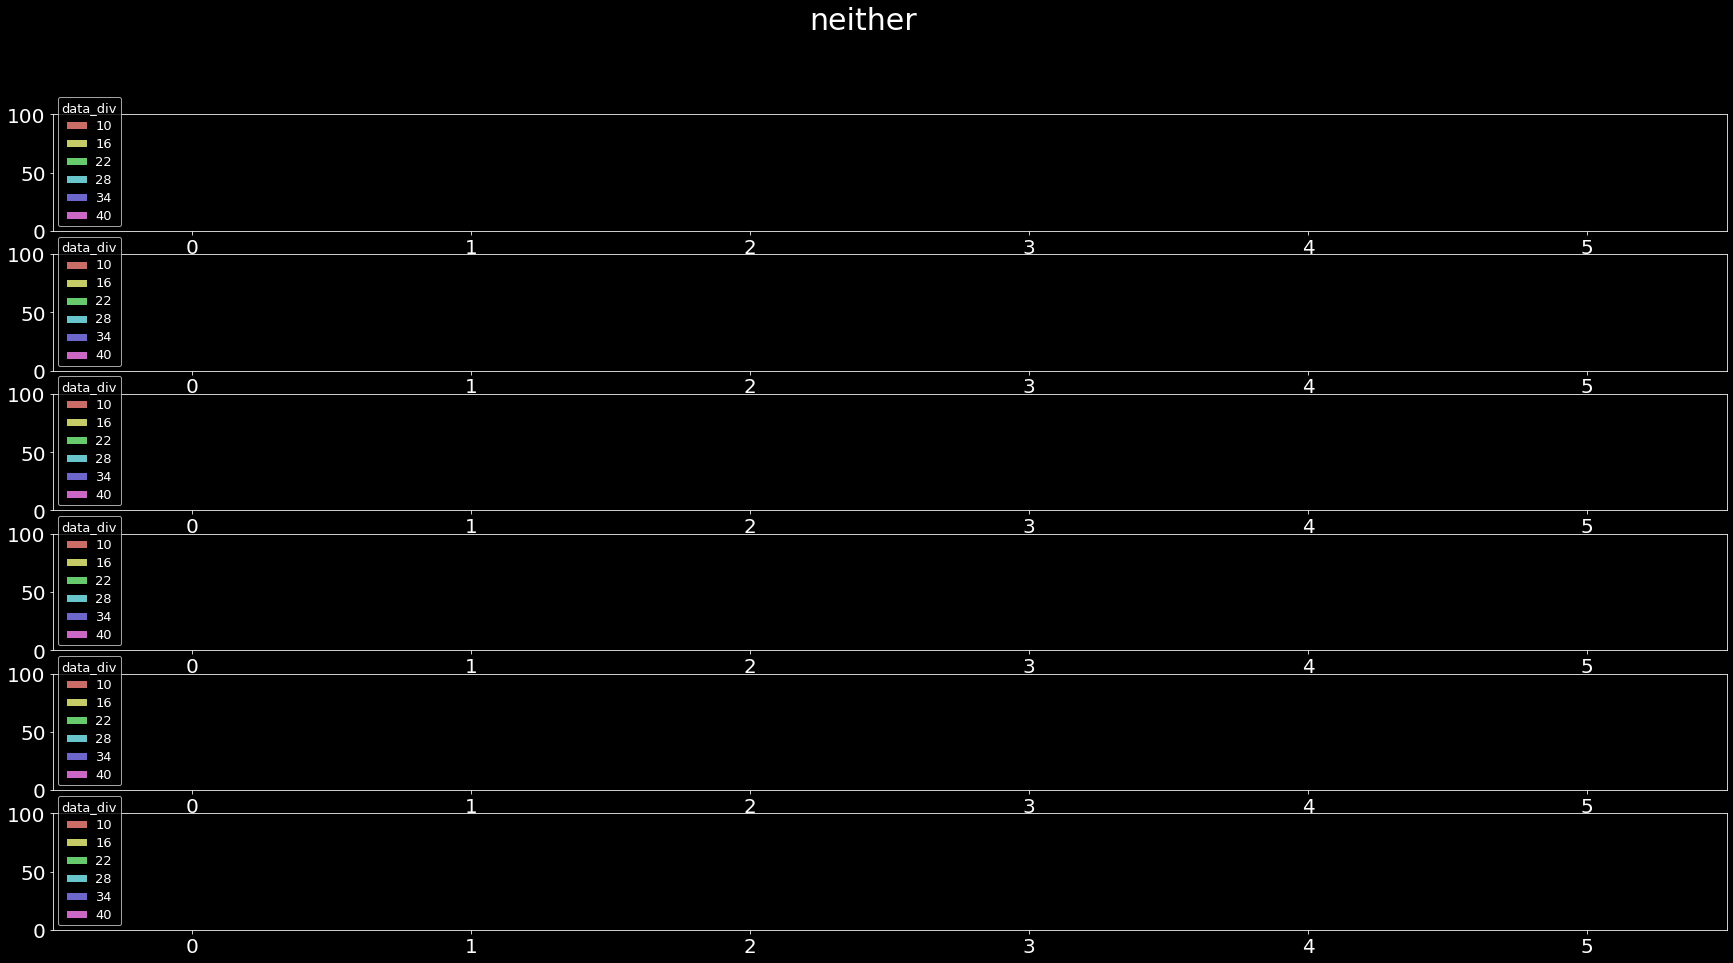

In [82]:
plt.close('all')
# pdf = matplotlib.backends.backend_pdf.PdfPages("/home/avic/exclude_unique.pdf")
for df, name in zip([unseen, seen, mixed, neither], ['unseen', 'seen', 'mixed', 'neither']):
    fig, axes = plt.subplots(6, 1, figsize=(30,15))
    fig.suptitle(name, fontsize=30)
    for x in range(6):
        a = sns.barplot(x='cluster', y='selective_to', data=get_unique_categories(df, base=x).reset_index(), hue='data_div', palette=sns.color_palette("hls", 6), ax=axes[x])
        axes[x].set(ylim=(0, 100))
        axes[x].tick_params(labelsize=20)
        a.set_xlabel('')
        a.set_ylabel('')
        plt.setp(a.get_legend().get_texts(), fontsize='13') # for legend text
        plt.setp(a.get_legend().get_title(), fontsize='13') # for legend title
    plt.show()
#     pdf.savefig(fig)
# pdf.close()

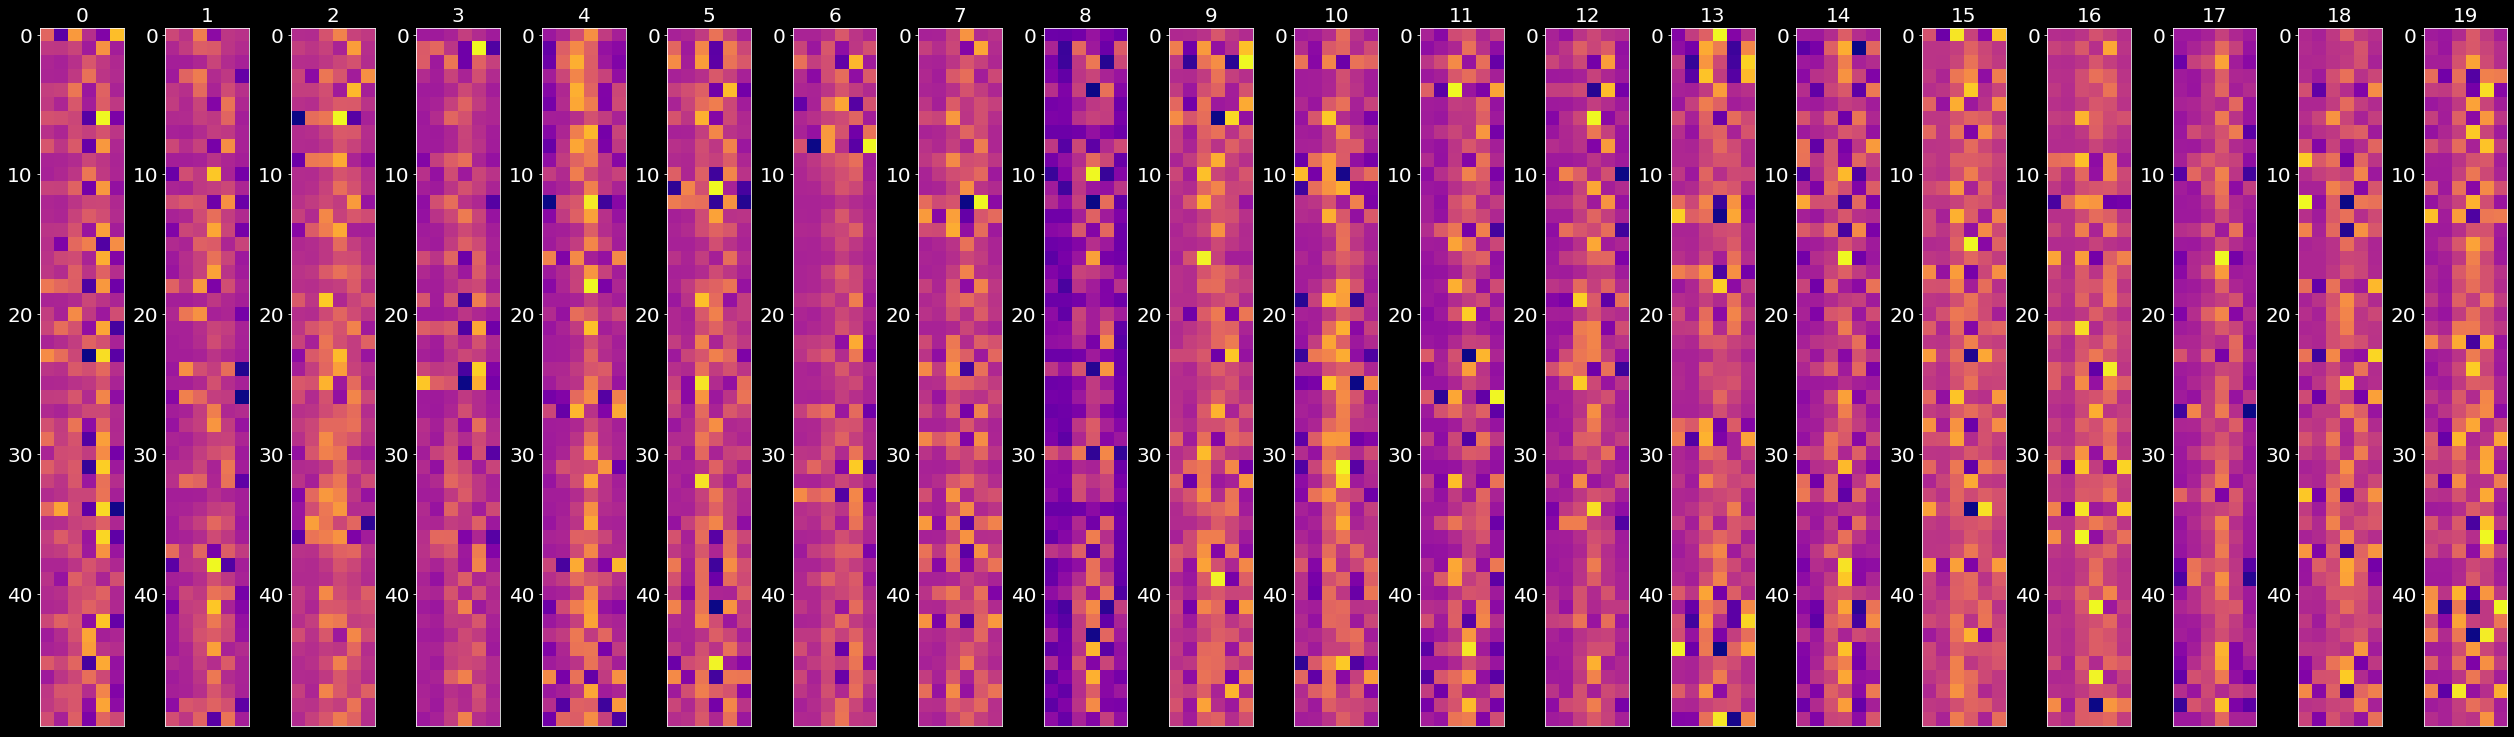

In [75]:
draw_cols(d, 'ssim', 40, range(20))

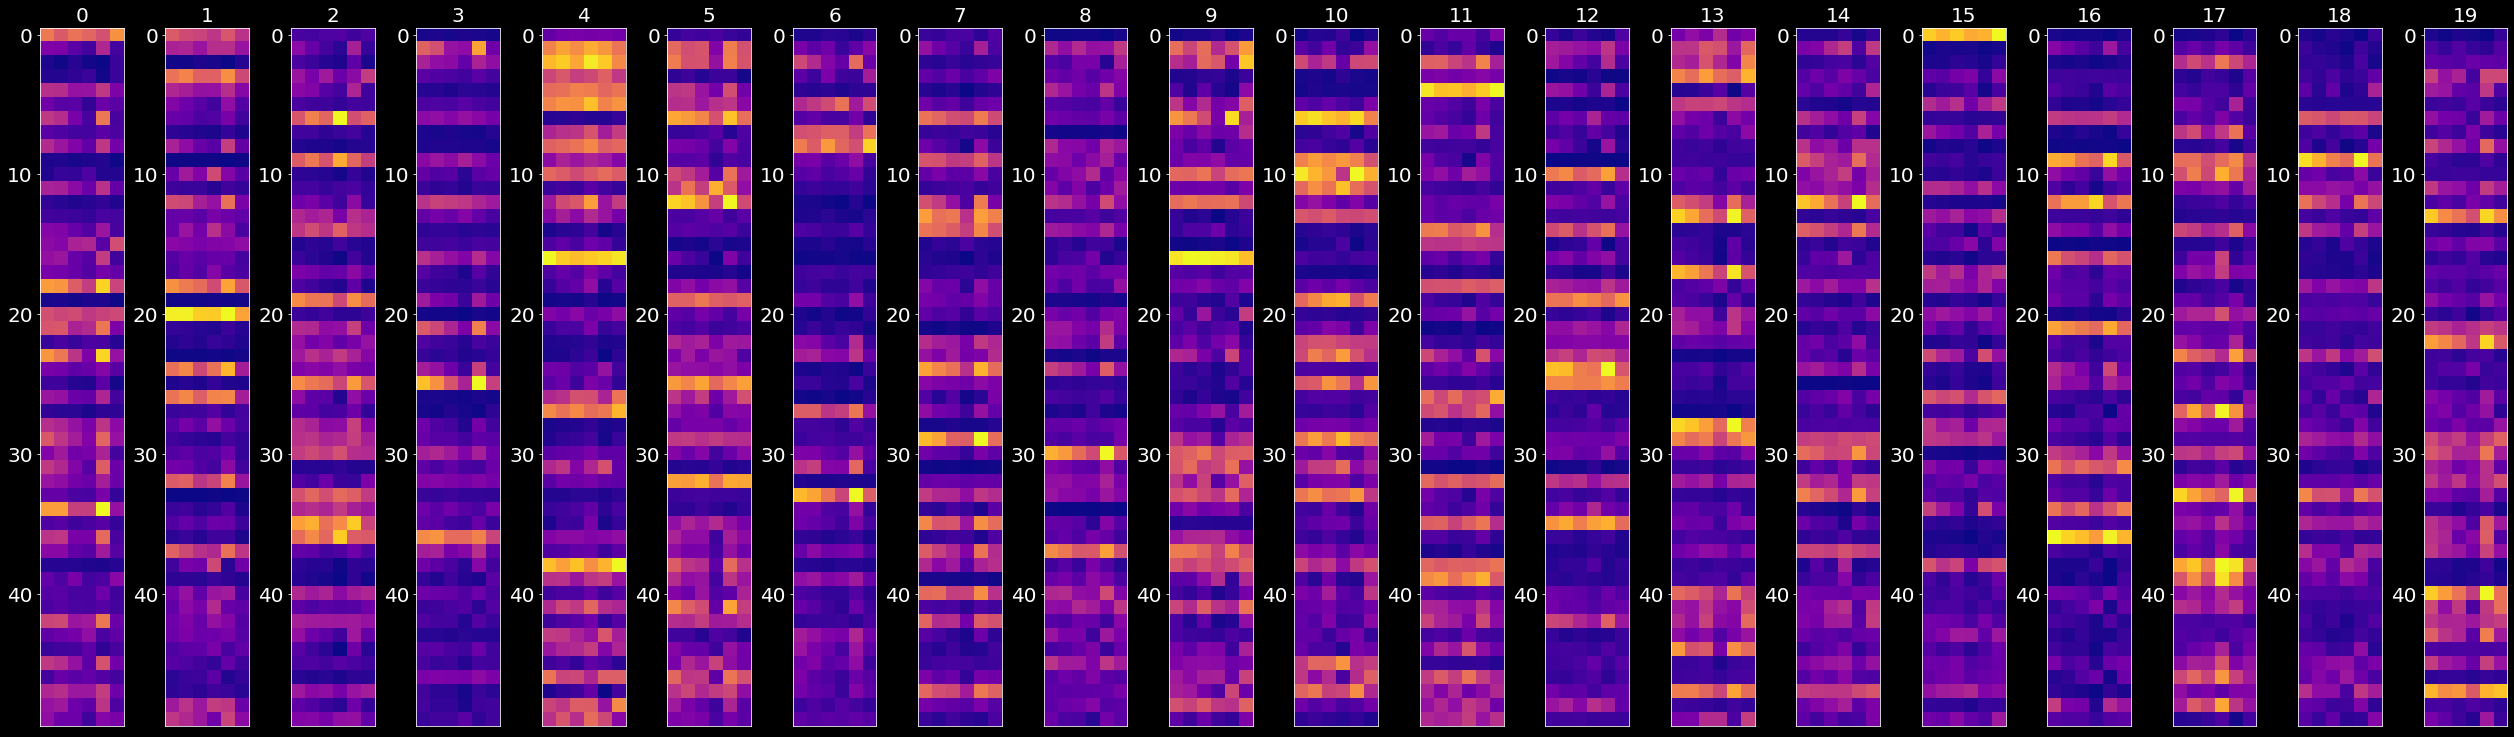

In [76]:
draw_cols(d, 'activations', 40, range(20))

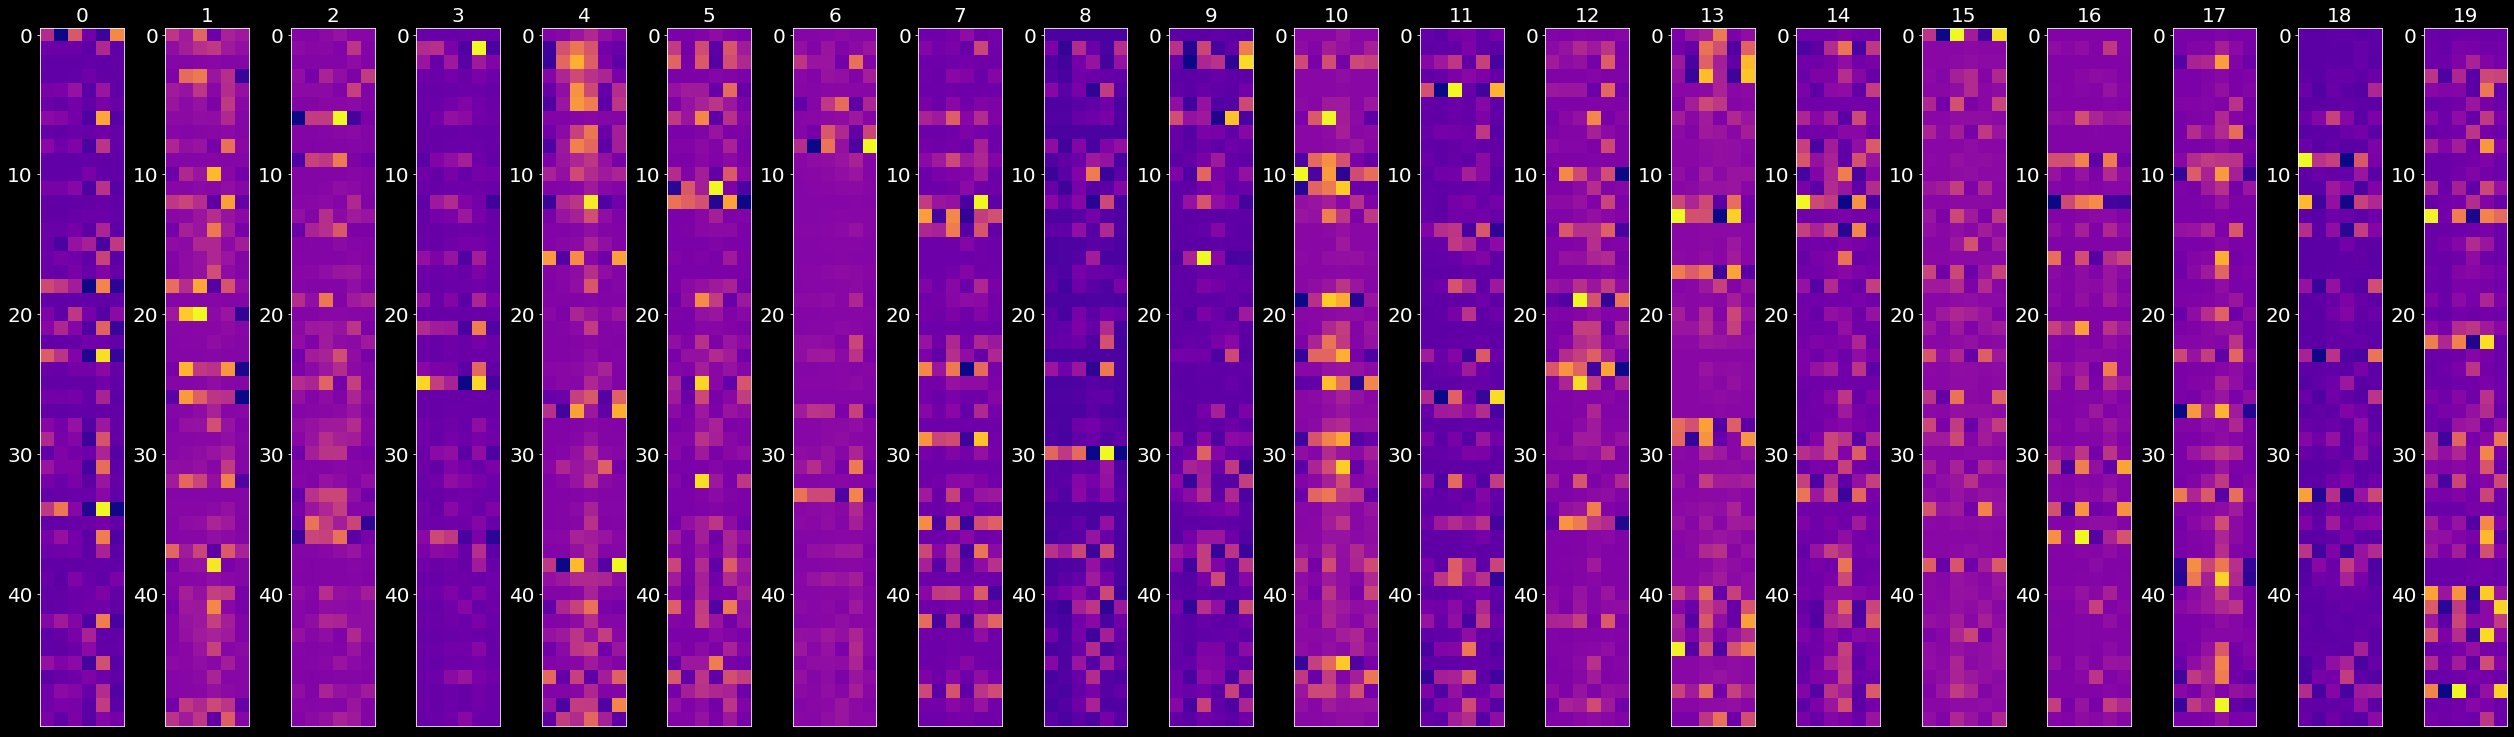

In [77]:
draw_cols(d, 'similarity', 40, range(20))

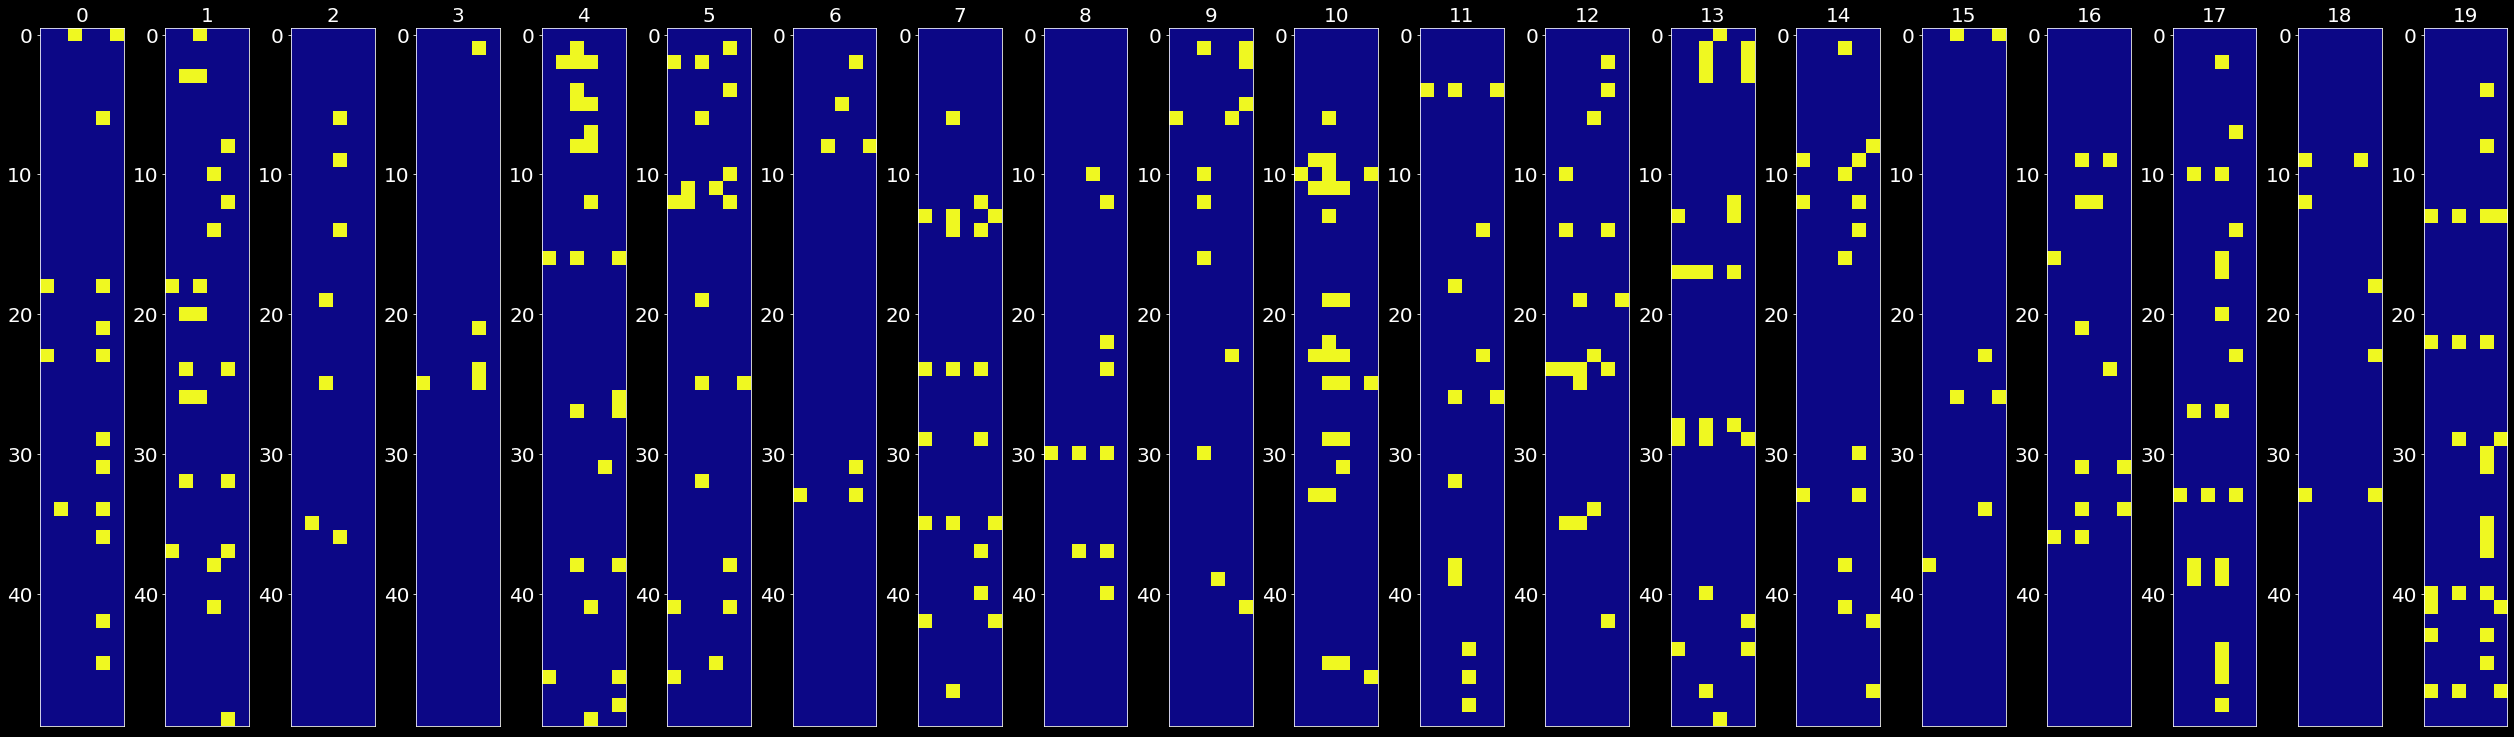

In [78]:
draw_cols(d, 'selective_to', 40, range(20))

In [83]:
def get_unique_neurons(df):
    temp_df = df.groupby([df.data_div, df.cluster]).apply(lambda group: np.unique(group.neuron)).reset_index()
    temp_df['num_neurons'] = temp_df[0].apply(lambda x: len(x))
    temp_df['proportion'] = temp_df.apply(lambda group: group.num_neurons * (group.data_div / 50), axis=1)
    return temp_df

def get_neuron_invars(df, np_f):
    return df.groupby([df.data_div, df.neuron, df.cluster]).apply(lambda group: np_f(group.invariance)).reset_index()

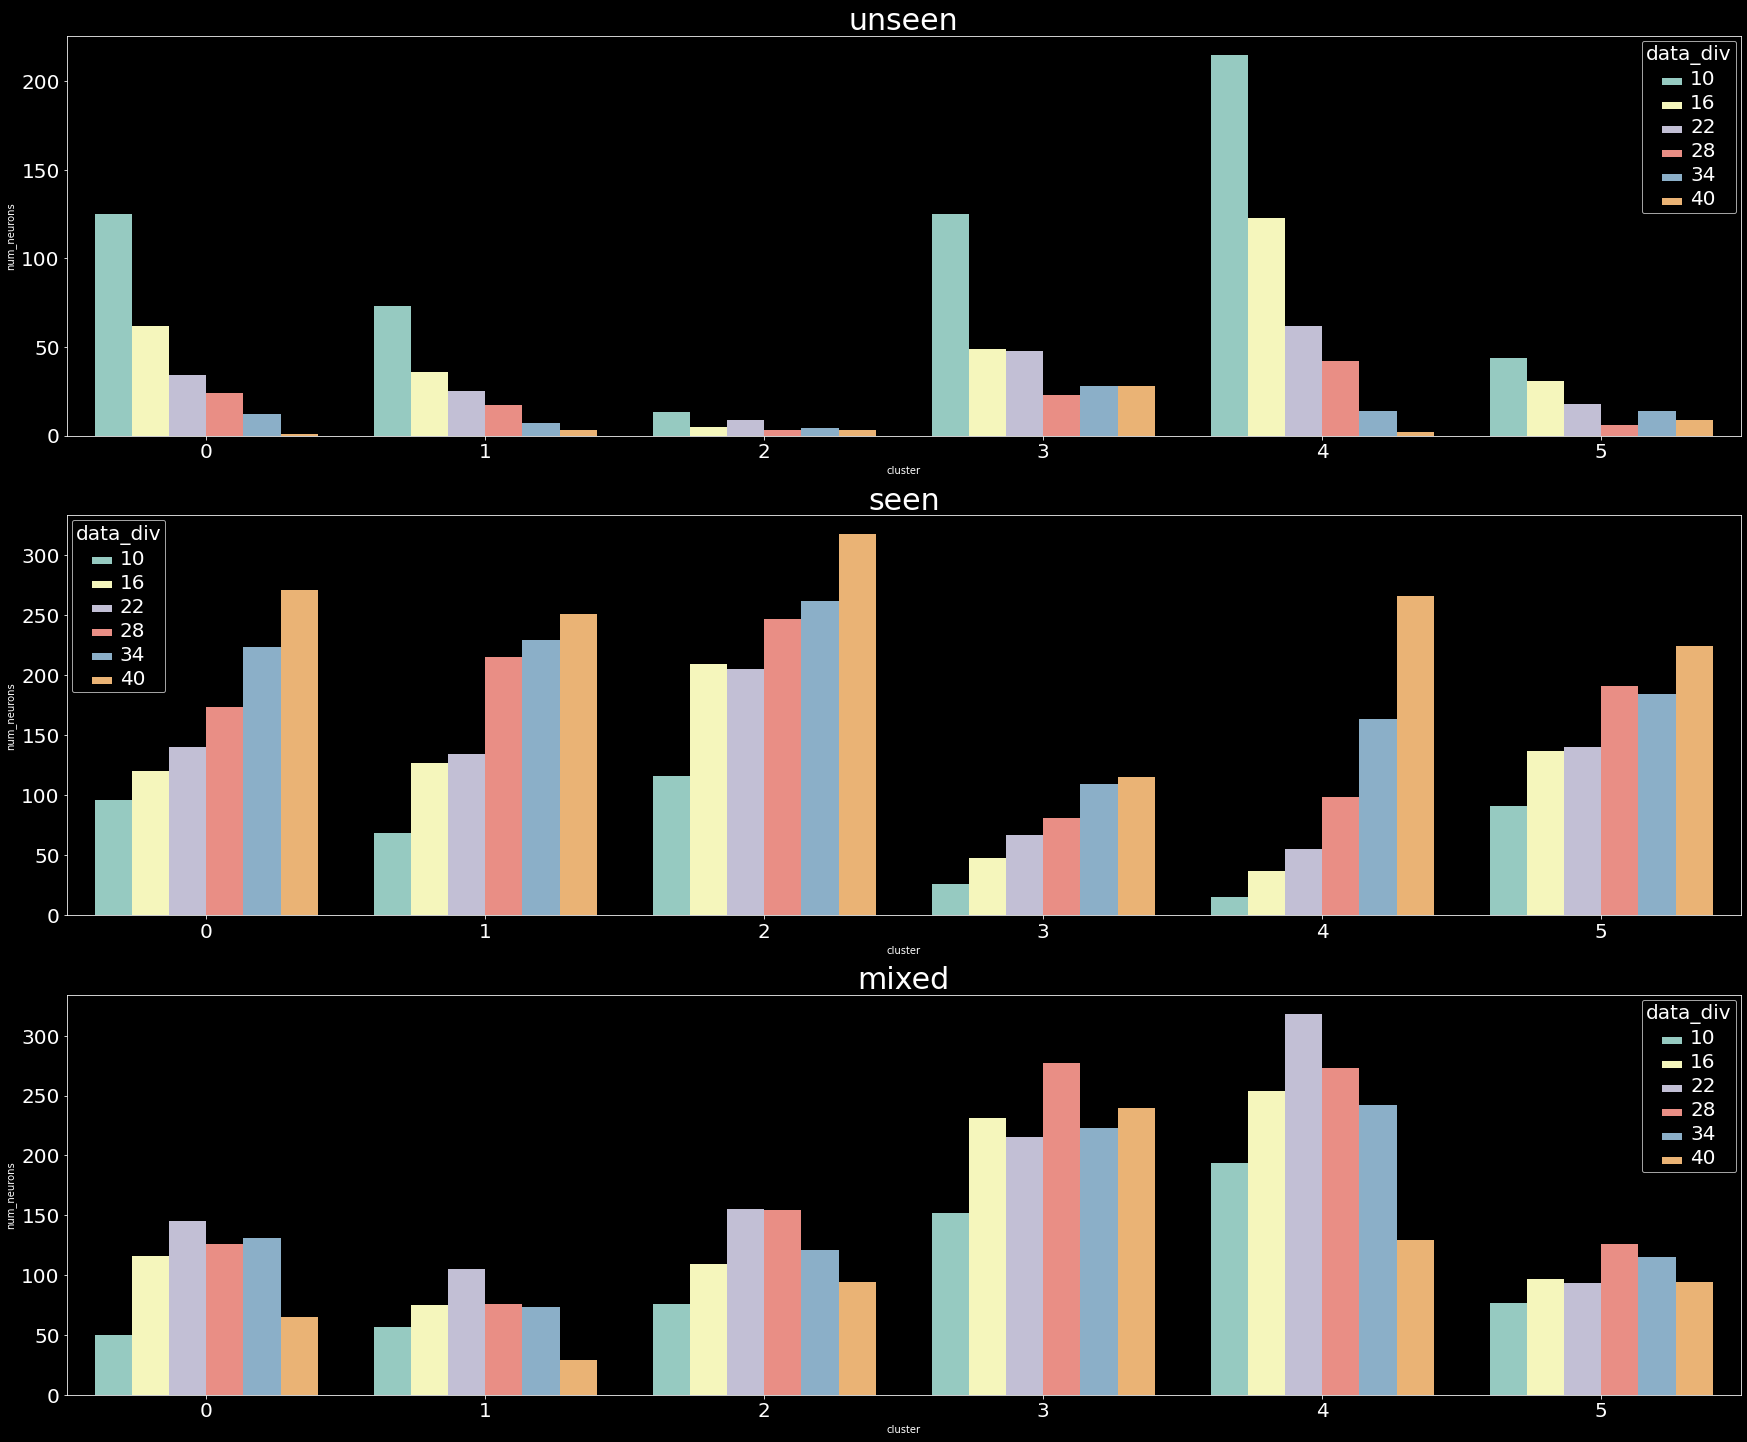

In [84]:
fig, axes = plt.subplots(3, 1, figsize=(30, 25))
for i, (n, name) in enumerate(zip([unseen, seen, mixed], ['unseen', 'seen', 'mixed'])):
    a = sns.barplot(ax=axes[i], x='cluster', y='num_neurons', data=get_unique_neurons(n), hue='data_div')
    axes[i].set_title(name, fontsize=30)
    axes[i].tick_params(labelsize=20)
    plt.setp(a.get_legend().get_texts(), fontsize='20') # for legend text
    plt.setp(a.get_legend().get_title(), fontsize='20') # for legend title
plt.show()

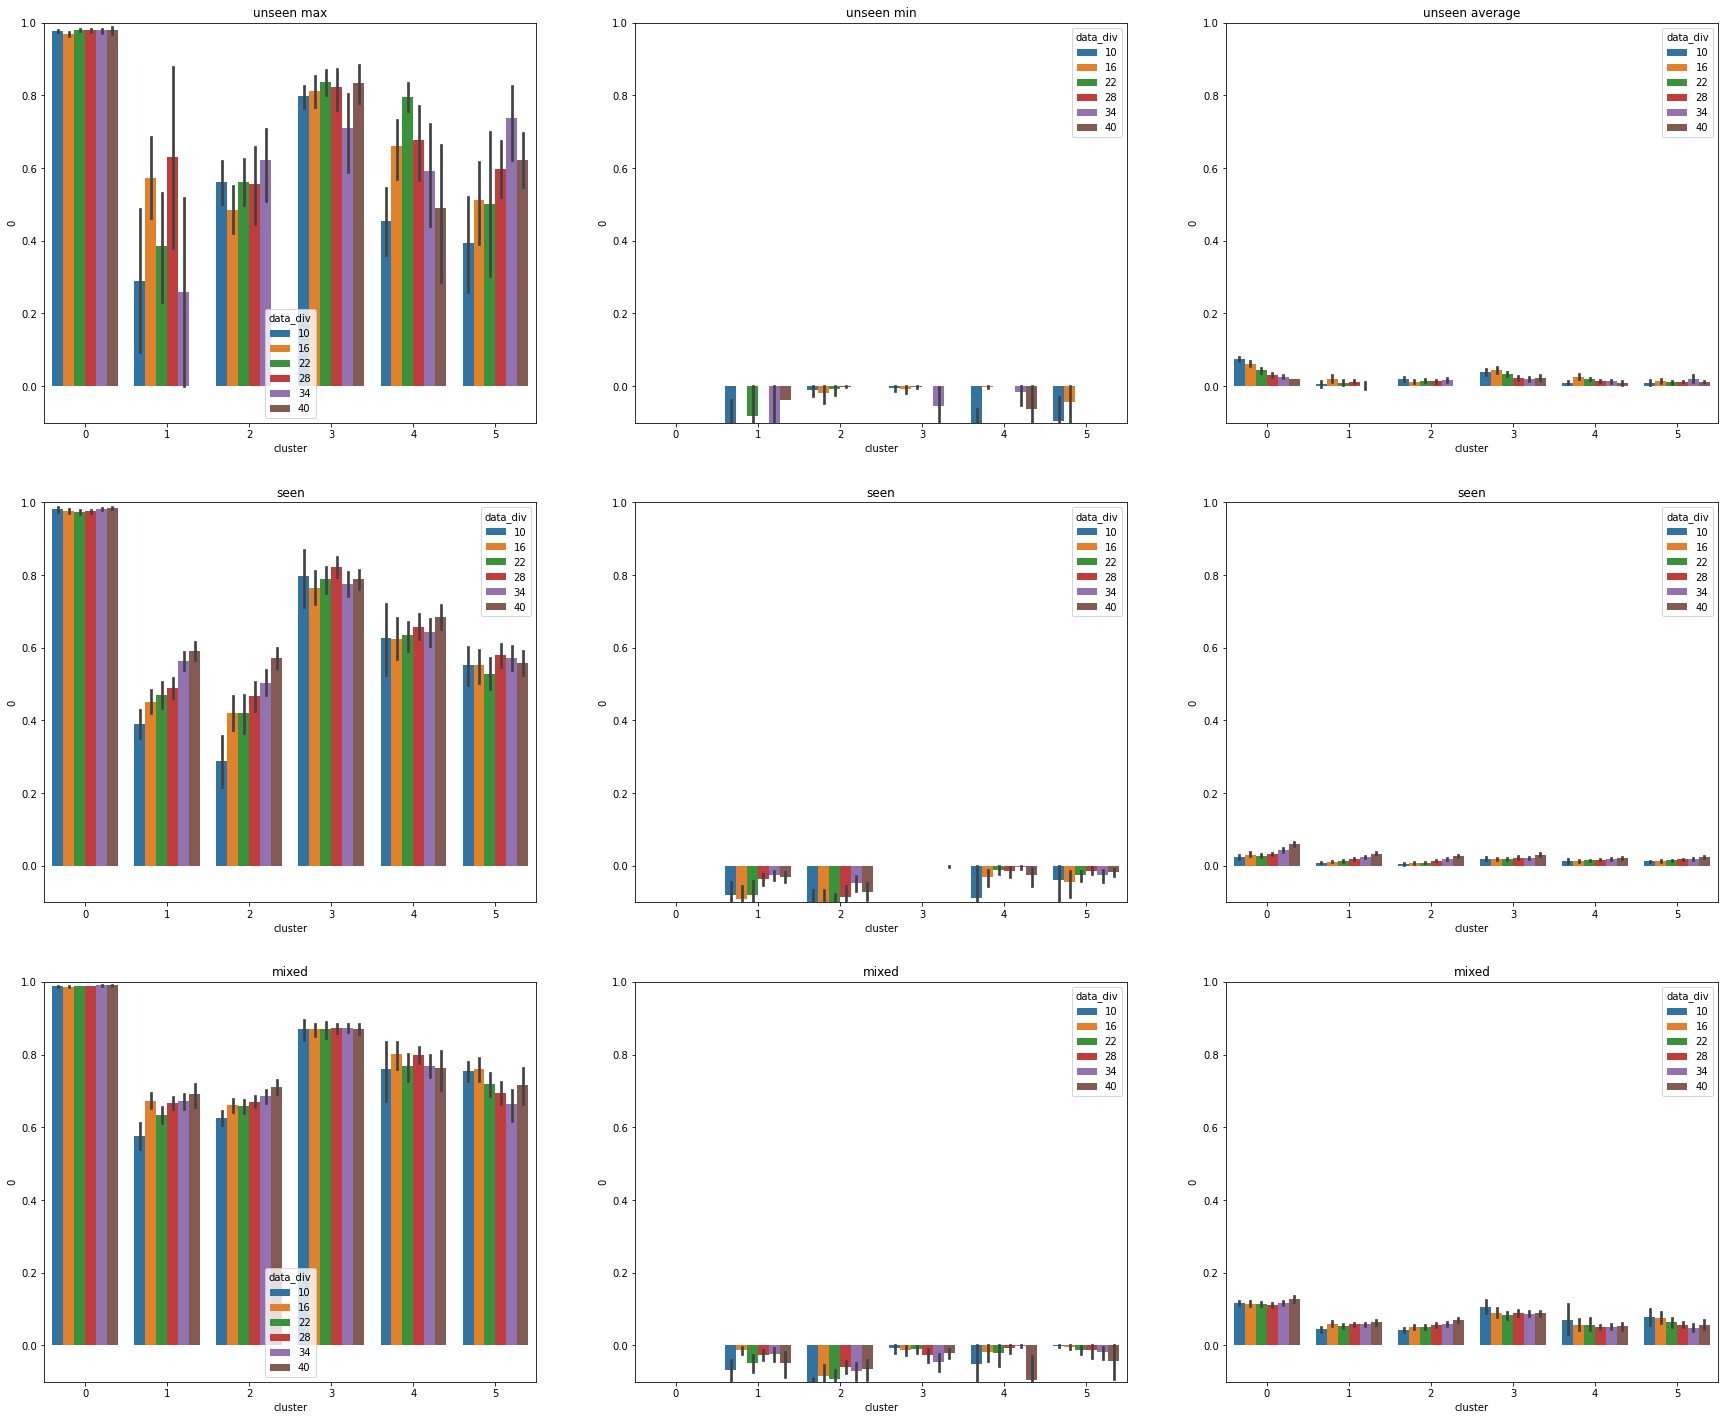

In [223]:
fig, axes = plt.subplots(3, 3, figsize=(30, 25))
for i, (n, name) in enumerate(zip([unseen, seen, mixed], ['unseen', 'seen', 'mixed'])):
    for q, (np_f, f_name) in enumerate(zip([np.amax, np.amin, np.average], ['max', 'min', 'average'])):
        sns.barplot(ax=axes[i][q], x='cluster', y=0, data=get_neuron_invars(n, np_f), hue='data_div')
        axes[i][q].set_title(f'{name}{"" if i != 0 else f" {f_name}"}')
        axes[i][q].set(ylim=(-0.1, 1))
plt.show()

In [ ]:
fig, axes = plt.subplots(3, 1, figsize=(30, 25))
for i, (n, name) in enumerate(zip([unseen, seen, mixed], ['unseen', 'seen', 'mixed'])):
    sns.violinplot(ax=axes[i], x='cluster', y=0, data=get_neuron_invars(n, np_f), hue='data_div')
    axes[i].set_title(name)
#     axes[i].set(ylim=(-0.1, 1))
plt.show()

In [ ]:
draw(relevant_heatmaps[5], 35)

In [ ]:
a = np.load(os.path.join(EXP_DIR, 'eval', f'split_heatmaps.npy'))

In [ ]:
plt.subplots(figsize=(10,50))
a[0,:,0,:] = 1
plt.imshow(a[5].reshape((25 * 50, 25)))